In [1]:
import xml.etree.ElementTree as Xet
import pandas as pd
import sys
import numpy as np
import geopandas as gp
import matplotlib.pyplot as plt

# Precinct Shapefile

## VEST's Documentation File

Election results from Arizona Secretary of State (https://azsos.gov/2020-election-information)
Precinct shapefile from Arizona Secretary of State via personal communication except Greenlee County is sourced from the county shapefile instead.

The following modifications were made to match the precinct boundaries for the 2020 general election.

Apache: Merge Puerco East/West

La Paz: Merge Alamo into Wenden

Maricopa: Merge South Mtn Park E, NE, S, SE, SW into South Mtn Park

- G20PRERTRU - Donald J. Trump (Republican Party)
- G20PREDBID - Joseph R. Biden (Democratic Party)
- G20PRELJOR - Jo Jorgensen (Libertarian Party)
- G20USSDKEL - Mark Kelly (Democratic Party)
- G20USSRMCS - Martha McSally (Republican Party)


## Load VEST's Final File

In [2]:
vest_shp = gp.read_file("./raw-from-source/VEST/az_2020/az_2020.shp")

In [3]:
vest_shp.shape

(1489, 9)

In [4]:
vest_shp.head(1)

,CDE_COUNTY,PCTNUM,PRECINCTNA,G20PREDBID,G20PRERTRU,G20PRELJOR,G20USSDKEL,G20USSRMCS,geometry
0,AP,AP0002,ALPINE,94,283,5,98,284,"POLYGON ((-109.49567 33.65280, -109.49576 33.6..."


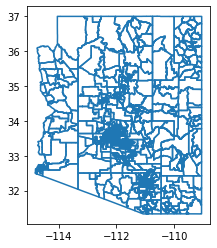

In [5]:
vest_shp.boundary.plot()

## Load Source Precinct File

VEST does not specify their source. This file is from Garrett Archer, but is a 2018 file. 

In [6]:
precincts = gp.read_file("./raw-from-source/az_vtd_2018_v2/az_vtd_2018_new_pima.shp")

In [7]:
precincts.shape

(1496, 6)

In [8]:
precincts.head(1)

,pctnum,precinctna,cde_county,DIST_CON,DIST_LEG,geometry
0,AP0002,ALPINE,AP,NaN,NaN,"POLYGON ((-109.49567 33.65280, -109.49576 33.6..."


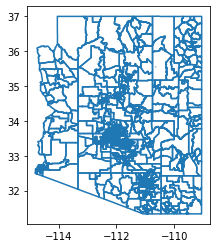

In [9]:
precincts.boundary.plot()

## Seeing if Source File is the same as 2018 File

Outer join the VEST's file and the raw precinct file on `pctnum`

In [10]:
vest_raw_joined = pd.merge(vest_shp,precincts,
                              left_on=['PCTNUM'],right_on=['pctnum'],
                              how='outer',indicator=True)

In [11]:
vest_raw_joined.groupby('_merge').count()

,CDE_COUNTY,PCTNUM,PRECINCTNA,G20PREDBID,G20PRERTRU,G20PRELJOR,G20USSDKEL,G20USSRMCS,geometry_x,pctnum,precinctna,cde_county,DIST_CON,DIST_LEG,geometry_y
_merge,,,,,,,,,,,,,,,
left_only,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
right_only,0,0,0,0,0,0,0,0,0,7,7,7,0,0,7
both,1489,1489,1489,1489,1489,1489,1489,1489,1489,1489,1489,1489,249,249,1489


In [12]:
#Want to check this in the "both" match as well as the shapefile match
first_check = vest_raw_joined[(vest_raw_joined["_merge"]=="both")]

pdv_shapes_elections_and_shapes = gp.GeoDataFrame(first_check, geometry='geometry_y')
vest_shapes_elections_and_shapes = gp.GeoDataFrame(first_check, geometry='geometry_x')

pdv_shapes_elections_and_shapes.crs=vest_shapes_elections_and_shapes.crs

In [13]:
pdv_shapes_elections_and_shapes.geom_almost_equals(vest_shapes_elections_and_shapes,
                                                   decimal=1).value_counts()

True     1472
False      17
dtype: int64

See if the 17 precincts that don't match the same geographies are all in Grenlee county, because VEST documentation said: 
> Precinct shapefile from Arizona Secretary of State via personal communication except Greenlee County is sourced from the county shapefile instead.


In [14]:
s = pdv_shapes_elections_and_shapes.geom_almost_equals(vest_shapes_elections_and_shapes,
                                                   decimal=1)
vest_shapes_elections_and_shapes.iloc[s[~s].index].groupby('CDE_COUNTY')['PCTNUM'].count()

CDE_COUNTY
AP    1
CH    1
GN    8
LP    1
MC    1
NA    1
YA    4
Name: PCTNUM, dtype: int64

So the VEST shapefile is the same as the 2018 one from Garrett Archer, except in 17 precincts, where 8 of those 17 precincts are the ones from Grenlee County that VEST subbed in with the county shapefile. 

The RDH determined that we will not attempt to validate the VEST 2020 shapefile against the 2018 file from Garrett Archer, because we do not know if the 2018 file is an accurate representation of the geographies of precincts at the time of the 2020 election. We reached out to Garrett Archer on 6/14/2021 to see if he has the 2020 file and did not hear back as of 6/29/2021. 

# Election Results

## Converting Election Results XML

Running the cell below initially gave the following error: `IOPub data rate exceeded. The Jupyter server will temporarily stop sending output to the client in order to avoid crashing it.`

To fix this, run the jupyter notebook from terminal with: 
`jupyter notebook --NotebookApp.iopub_data_rate_limit=1.0e10` or `jupyter-lab --NotebookApp.iopub_data_rate_limit=1e10
`

In [15]:
cols = ["contest", "participatingJurisdictions", "choice", "precinct", "voteType"]
rows = []
  
xmlparse = Xet.parse('./raw-from-source/SOS/Results.Detail_2020General.xml')
root = xmlparse.getroot()

data = []
lower = root.findall(".//contest")
for i in lower:
    contest = i.attrib.get('contestLongName')
    lower1 = i.findall('.//choice')
    for j in lower1:
        choice = j.attrib.get('choiceName')
        party = j.attrib.get('party')
        total_votes = j.attrib.get('totalVotes')
        is_write_in = j.attrib.get('isWriteIn')
        lower2 = j.findall('.//jurisdiction')
        for k in lower2:
            jurisdiction_key = k.attrib.get('key')
            jurisdiction_name = k.attrib.get('name')
            jurisdiction_total = k.attrib.get('votes')
            lower3 = k.findall('.//precinct')
            for l in lower3:
                precinct_key = l.attrib.get('key')
                precinct_name = l.attrib.get('name')
                precinct_votes = l.attrib.get('votes')
                data.append([contest, choice, party, total_votes, is_write_in, jurisdiction_key, jurisdiction_name, jurisdiction_total, 
                                 precinct_key, precinct_name, precinct_votes])

dfcols = ['contest','choice','party','total_votes','is_write_in','jurisdiction_key','jurisdiction_name','jurisdiction_total',
          'precinct_key','precinct_name','precinct_votes']
df = pd.DataFrame(data,columns=dfcols)

In [16]:
df["precinct_votes"]=df["precinct_votes"].astype(int)
df = df[df["contest"].isin(['President of the United States','U.S. Senator (Term Expires Jan. 2023)'])]
df = df[df["choice"].isin(['Biden, Joseph','Jorgensen, Jo','Trump, Donald J.','Kelly, Mark','McSally, Martha'])]
df = df[df["jurisdiction_name"] != "State"]

In [17]:
df.groupby(['contest','choice'])['precinct_votes'].sum()

contest                                choice          
President of the United States         Biden, Joseph       1672143
                                       Jorgensen, Jo         51465
                                       Trump, Donald J.    1661686
U.S. Senator (Term Expires Jan. 2023)  Kelly, Mark         1716467
                                       McSally, Martha     1637661
Name: precinct_votes, dtype: int64

In [18]:
df.head()

,contest,choice,party,total_votes,is_write_in,jurisdiction_key,jurisdiction_name,jurisdiction_total,precinct_key,precinct_name,precinct_votes
0,President of the United States,"Biden, Joseph",DEM,1672143,false,1,Apache,23293,9179,02 ALPINE,94
1,President of the United States,"Biden, Joseph",DEM,1672143,false,1,Apache,23293,9180,03 CANYON DE CHELLY,1982
2,President of the United States,"Biden, Joseph",DEM,1672143,false,1,Apache,23293,9181,05 CHINLE,989
3,President of the United States,"Biden, Joseph",DEM,1672143,false,1,Apache,23293,9182,09 CONCHO,333
4,President of the United States,"Biden, Joseph",DEM,1672143,false,1,Apache,23293,9183,10 CORNFIELDS,393


## Pivoting Election Results

In [19]:
election_results = df.pivot_table(index = ['jurisdiction_name','jurisdiction_key','precinct_key','precinct_name'],
                         columns = ['contest','choice','party'],
                        values = ['precinct_votes'],
                         aggfunc = 'sum')
election_results.reset_index(inplace = True)
election_results.head()

jurisdiction_name jurisdiction_key precinct_key        precinct_name  \
contest                                                                        
choice                                                                         
party                                                                          
0                  Apache                1         9179            02 ALPINE   
1                  Apache                1         9180  03 CANYON DE CHELLY   
2                  Apache                1         9181            05 CHINLE   
3                  Apache                1         9182            09 CONCHO   
4                  Apache                1         9183        10 CORNFIELDS   

                        precinct_votes                                 \
contest President of the United States                                  
choice                   Biden, Joseph Jorgensen, Jo Trump, Donald J.   
party                              DEM           LBT              REP   
0                                   94             5              283   
1                                 1982            30              273   
2                                  989            20              148   
3                                  333            22             1486   
4                                  393             4               76   

                                                               
contest U.S. Senator (Term Expires Jan. 2023)                  
choice                            Kelly, Mark McSally, Martha  
party                                     DEM             REP  
0                                          98             284  
1                                        1995             290  
2                                         994             157  
3                                         381            1422  
4                                         413              71

In [20]:
election_results.columns = ['county_name','county_key','precinct_key','precinct_name','G20PREDBID','G20PRELJOR','G20PRERTRU','G20USSDKEL','G20USSRMCS']
election_results.head()

,county_name,county_key,precinct_key,precinct_name,G20PREDBID,G20PRELJOR,G20PRERTRU,G20USSDKEL,G20USSRMCS
0,Apache,1,9179,02 ALPINE,94,5,283,98,284
1,Apache,1,9180,03 CANYON DE CHELLY,1982,30,273,1995,290
2,Apache,1,9181,05 CHINLE,989,20,148,994,157
3,Apache,1,9182,09 CONCHO,333,22,1486,381,1422
4,Apache,1,9183,10 CORNFIELDS,393,4,76,413,71


## Add County Fips

### To election results file

In [21]:
#Load in the nationwide FIPS file
fips_file = pd.read_csv("./raw-from-source/FIPS/US_FIPS_Codes.csv")
fips_file = fips_file[fips_file["State"]=="Arizona"]
fips_file["FIPS County"]=fips_file["FIPS County"].astype(str)

#Make the FIPS three digits
fips_file["FIPS County"]=fips_file["FIPS County"].str.zfill(3)

#Create the dictionary
az_fips_dict = dict(zip(fips_file["County Name"],fips_file["FIPS County"]))

In [22]:
election_results['COUNTYFP'] = election_results['county_name'].apply(lambda x: az_fips_dict.get(x))

In [23]:
election_results[['county_name','COUNTYFP']].drop_duplicates()

,county_name,COUNTYFP
0,Apache,001
44,Cochise,003
93,Coconino,005
164,Gila,007
203,Graham,009
225,Greenlee,011
233,La Paz,012
244,Maricopa,013
987,Mohave,015
1011,Navajo,017


### To VEST file

In [24]:
vest_shp['CDE_COUNTY'].unique()

array(['AP', 'CH', 'CN', 'GI', 'GM', 'LP', 'MO', 'PN', 'SC', 'YA', 'NA',
       'YU', 'MC', 'PM', 'GN'], dtype=object)

In [25]:
cde_county_dict = {'AP':'Apache', 'CH':'Cochise', 'CN':'Coconino', 'GI':'Gila', 'GM':'Graham', 'LP':'La Paz', 'MO':'Mohave', 'PN':'Pinal', 'SC':'Santa Cruz', 'YA':'Yavapai', 'NA':'Navajo',
       'YU':'Yuma', 'MC':'Maricopa', 'PM':'Pima', 'GN':'Greenlee'}

In [26]:
vest_shp['county_name'] = vest_shp['CDE_COUNTY'].apply(lambda x: cde_county_dict.get(x))
vest_shp['COUNTYFP'] = vest_shp['county_name'].apply(lambda x: az_fips_dict.get(x))
vest_shp[['county_name','COUNTYFP']].drop_duplicates()

,county_name,COUNTYFP
0,Apache,001
35,Cochise,003
53,Coconino,005
75,Gila,007
90,Graham,009
98,La Paz,012
108,Mohave,015
133,Pinal,021
151,Santa Cruz,023
162,Yavapai,025


## Merge Election Results from SOS to VEST

In [27]:
vest_shp.shape

(1489, 11)

In [28]:
election_results.shape

(1489, 10)

### Join Attempt #1

In [29]:
df_joined = vest_shp.merge(election_results, how = 'outer'
                            , left_on = ['COUNTYFP','PRECINCTNA'], right_on = ['COUNTYFP','precinct_name']
                            , indicator = True)

In [30]:
df_joined.groupby('_merge').count()

,CDE_COUNTY,PCTNUM,PRECINCTNA,G20PREDBID_x,G20PRERTRU_x,G20PRELJOR_x,G20USSDKEL_x,G20USSRMCS_x,geometry,county_name_x,COUNTYFP,county_name_y,county_key,precinct_key,precinct_name,G20PREDBID_y,G20PRELJOR_y,G20PRERTRU_y,G20USSDKEL_y,G20USSRMCS_y
_merge,,,,,,,,,,,,,,,,,,,,
left_only,1465,1465,1465,1465,1465,1465,1465,1465,1465,1465,1465,0,0,0,0,0,0,0,0,0
right_only,0,0,0,0,0,0,0,0,0,0,1465,1465,1465,1465,1465,1465,1465,1465,1465,1465
both,24,24,24,24,24,24,24,24,24,24,24,24,24,24,24,24,24,24,24,24


### Write both files to a CSV to line up by hand

In [31]:
vest_shp[['COUNTYFP','PCTNUM','PRECINCTNA','G20PREDBID']].to_csv('./raw-from-source/VEST/vest_county_precincts.csv')
election_results[['COUNTYFP','precinct_name','G20PREDBID']].to_csv('./raw-from-source/SOS/sos_county_precincts.csv')

Notes: 
- Gila County (007): compare VEST P/S EAST and P/S WEST with SOS
- Graham County (009): need to use the PCTNUM to figure out the 3 SAFFORD precincts

Lined up all of the precincts by hand and loading back in the dictionary file. 

In [32]:
precinct_dictionary = pd.read_csv('election_results_dictionary.csv', dtype = {'COUNTYFP_vest':'object','COUNTYFP_sos':'object'})
precinct_dictionary.head()

,COUNTYFP_vest,PCTNUM_vest,PRECINCTNA_vest,G20PREDBID_vest,COUNTYFP_sos,precinct_name_sos,G20PREDBID_sos
0,001,AP0002,ALPINE,94,001,02 ALPINE,94
1,001,AP0003,CANYON DE CHELLY,1982,001,03 CANYON DE CHELLY,1982
2,001,AP0005,CHINLE,989,001,05 CHINLE,989
3,001,AP0009,CONCHO,333,001,09 CONCHO,333
4,001,AP0010,CORNFIELDS,393,001,10 CORNFIELDS,393


In [33]:
vest_shp_merged = vest_shp.merge(precinct_dictionary, how = 'outer', left_on = ['PCTNUM'], 
                                                right_on = ['PCTNUM_vest'], indicator = True)

In [34]:
vest_shp_merged.groupby('_merge').count()

,CDE_COUNTY,PCTNUM,PRECINCTNA,G20PREDBID,G20PRERTRU,G20PRELJOR,G20USSDKEL,G20USSRMCS,geometry,county_name,COUNTYFP,COUNTYFP_vest,PCTNUM_vest,PRECINCTNA_vest,G20PREDBID_vest,COUNTYFP_sos,precinct_name_sos,G20PREDBID_sos
_merge,,,,,,,,,,,,,,,,,,
left_only,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
right_only,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
both,1489,1489,1489,1489,1489,1489,1489,1489,1489,1489,1489,1489,1489,1489,1489,1489,1489,1489


In [35]:
vest_shp_merged.drop(columns = ['_merge'], inplace = True)

### Join Attempt #2

In [36]:
vest_shp_merged.columns

Index(['CDE_COUNTY', 'PCTNUM', 'PRECINCTNA', 'G20PREDBID', 'G20PRERTRU',
       'G20PRELJOR', 'G20USSDKEL', 'G20USSRMCS', 'geometry', 'county_name',
       'COUNTYFP', 'COUNTYFP_vest', 'PCTNUM_vest', 'PRECINCTNA_vest',
       'G20PREDBID_vest', 'COUNTYFP_sos', 'precinct_name_sos',
       'G20PREDBID_sos'],
      dtype='object')

In [37]:
df_joined = vest_shp_merged.merge(election_results, how = 'outer'
                            , left_on = ['COUNTYFP','precinct_name_sos'], right_on = ['COUNTYFP','precinct_name']
                            , indicator = True)

In [38]:
df_joined.groupby('_merge').count()

,CDE_COUNTY,PCTNUM,PRECINCTNA,G20PREDBID_x,G20PRERTRU_x,G20PRELJOR_x,G20USSDKEL_x,G20USSRMCS_x,geometry,county_name_x,...,G20PREDBID_sos,county_name_y,county_key,precinct_key,precinct_name,G20PREDBID_y,G20PRELJOR_y,G20PRERTRU_y,G20USSDKEL_y,G20USSRMCS_y
_merge,,,,,,,,,,,,,,,,,,,,,
left_only,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
right_only,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
both,1489,1489,1489,1489,1489,1489,1489,1489,1489,1489,...,1489,1489,1489,1489,1489,1489,1489,1489,1489,1489


In [39]:
df_joined.head()

,CDE_COUNTY,PCTNUM,PRECINCTNA,G20PREDBID_x,G20PRERTRU_x,G20PRELJOR_x,G20USSDKEL_x,G20USSRMCS_x,geometry,county_name_x,...,county_name_y,county_key,precinct_key,precinct_name,G20PREDBID_y,G20PRELJOR_y,G20PRERTRU_y,G20USSDKEL_y,G20USSRMCS_y,_merge
0,AP,AP0002,ALPINE,94,283,5,98,284,"POLYGON ((-109.49567 33.65280, -109.49576 33.6...",Apache,...,Apache,1,9179,02 ALPINE,94,5,283,98,284,both
1,AP,AP0003,CANYON DE CHELLY,1982,273,30,1995,290,"POLYGON ((-109.71666 36.26151, -109.71658 36.2...",Apache,...,Apache,1,9180,03 CANYON DE CHELLY,1982,30,273,1995,290,both
2,AP,AP0005,CHINLE,989,148,20,994,157,"POLYGON ((-109.81183 36.27512, -109.80810 36.2...",Apache,...,Apache,1,9181,05 CHINLE,989,20,148,994,157,both
3,AP,AP0009,CONCHO,333,1486,22,381,1422,"POLYGON ((-109.53982 34.44871, -109.53928 34.4...",Apache,...,Apache,1,9182,09 CONCHO,333,22,1486,381,1422,both
4,AP,AP0011,COTTONWOOD,748,87,5,763,85,"POLYGON ((-109.81768 36.14760, -109.81822 36.1...",Apache,...,Apache,1,9184,11 COTTONWOOD,748,5,87,763,85,both


# Election Results Validation

## Race Totals

In [40]:
vest_shp.columns

Index(['CDE_COUNTY', 'PCTNUM', 'PRECINCTNA', 'G20PREDBID', 'G20PRERTRU',
       'G20PRELJOR', 'G20USSDKEL', 'G20USSRMCS', 'geometry', 'county_name',
       'COUNTYFP'],
      dtype='object')

In [41]:
data_columns = ['G20PREDBID', 'G20PRERTRU','G20PRELJOR', 'G20USSDKEL', 'G20USSRMCS']

print("Printing differences below")
for race in data_columns:
    if (sum(vest_shp[race])-sum(election_results[race]) != 0):
        print(race+" has a difference of "+str(sum(vest_shp[race])-sum(election_results[race]))+" votes")
        print("\tVEST: "+str(sum(vest_shp[race]))+" votes")
        print("\tSOURCES: "+str(sum(election_results[race]))+" votes")
    else:
        print()
print("")
print("All other races are equal")


Printing differences below






All other races are equal


## County-by-County Totals

In [42]:
print("Counties with differences printed below:")
diff_counties=[]
for i in data_columns:
    diff = vest_shp.groupby(["COUNTYFP"]).sum()[i]-election_results.groupby(["COUNTYFP"]).sum()[i]
    for val in diff[diff != 0].index.values.tolist():
        if val not in diff_counties:
            diff_counties.append(val)
    if len(diff[diff != 0]!=0):
        print(i)
        print(diff[diff != 0].to_string(header=False))
print("")
print("All other races in all counties are equal")

Counties with differences printed below:

All other races in all counties are equal


## Precinct-by-Precinct Votes

In [43]:
def validater_row (df, column_List, final_join_col):
    matching_rows = 0
    different_rows = 0
    diff_list=[]
    diff_values = []
    max_diff = 0
    for j in range(0,len(df.index)):
        same = True
        for i in column_List:
            left_Data = i + "_x"
            right_Data = i + "_y"
            diff = abs(df.iloc[j][left_Data]-df.iloc[j][right_Data])
            if(diff >0):
                if(diff>0):
                    print(i, "{:.>72}".format(df.iloc[j][final_join_col]), "(V)","{:.>5}".format(int(df.iloc[j][left_Data]))," (S){:.>5}".format(int(df.iloc[j][right_Data])),"(D):{:>5}".format(int(df.iloc[j][right_Data])-int(df.iloc[j][left_Data])))           
                #print(df.iloc[j]['countypct'])
                
                diff_values.append(abs(diff))
                same = False
                if(np.isnan(diff)):
                    print("NaN value at diff is: ", df.iloc[j][final_join_col])
                    print(df.iloc[j][left_Data])
                    print(df.iloc[j][right_Data])
                if (diff>max_diff):
                    max_diff = diff
                    #print("New max diff is: ", str(max_diff))
                    #print(df.iloc[j]['cty_pct'])
        if(same != True):
            different_rows +=1
            diff_list.append(df.iloc[j][final_join_col])
        else:
            matching_rows +=1
    print("")
    print("There are ", len(df.index)," total rows")
    print(different_rows," of these rows have election result differences")
    print(matching_rows," of these rows are the same")
    print("")
    print("The max difference between any one shared column in a row is: ", max_diff)
    if(len(diff_values)!=0):
        print("The average difference is: ", str(sum(diff_values)/len(diff_values)))
    count_big_diff = len([i for i in diff_values if i > 10])
    print("There are ", str(count_big_diff), "precinct results with a difference greater than 10")
    diff_list.sort()
    print(diff_list)

df_joined['join_col'] = df_joined['COUNTYFP'] + df_joined['PRECINCTNA']
validater_row(df_joined,data_columns,'join_col')



There are  1489  total rows
0  of these rows have election result differences
1489  of these rows are the same

The max difference between any one shared column in a row is:  0
There are  0 precinct results with a difference greater than 10
[]
